In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../saved/final_dataset_cs_papers_last_20.csv", index_col='PaperId')

In [2]:
normalized_cc = df["CitationCountPerYear"].values
normalized_cc.shape

(61019,)

In [3]:
print(f"Max number of citations per year: {np.max(normalized_cc)}")
print(f"Median number of citations per year: {np.median(normalized_cc)}")
print(f"Mean number of citations per year: {np.mean(normalized_cc)}")
print(f"Std number of citations per year: {np.std(normalized_cc)}")

print(f"Number of papers with 0 citations: {np.sum((normalized_cc == 0))}")
print(f"Number papers with over 1 citation per year: {np.sum(normalized_cc > 1)}")
print(f"Number papers with over 5 citations per year: {np.sum(normalized_cc > 5)}")
print(f"Number papers with over 25 citations per year: {np.sum(normalized_cc > 25)}")
print(f"Number papers with over 100 citations per year: {np.sum(normalized_cc > 100)}")
print(f"Number papers with over 1k citations per year: {np.sum(normalized_cc > 1000)}")


Max number of citations per year: 1143.3305548940225
Median number of citations per year: 0.6211003970504821
Mean number of citations per year: 2.8393615494580478
Std number of citations per year: 12.939019144245327
Number of papers with 0 citations: 10686
Number papers with over 1 citation per year: 23794
Number papers with over 5 citations per year: 7443
Number papers with over 25 citations per year: 936
Number papers with over 100 citations per year: 123
Number papers with over 1k citations per year: 1


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6095a4dc0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

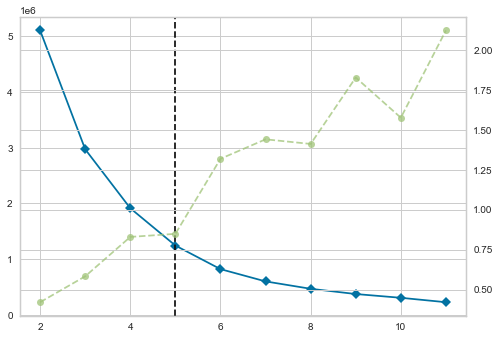

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(normalized_cc.reshape(-1, 1))

In [5]:
clstr = KMeans(n_clusters=4, random_state=0)
clstr.fit(normalized_cc.reshape(-1,1))
clstr.cluster_centers_

array([[ 29.26362672],
       [  1.58320266],
       [161.81378789],
       [576.03412154]])

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4, random_state=0)
gmm.fit(normalized_cc.reshape(-1,1))
gmm.means_

array([[ 0.17034089],
       [49.67828457],
       [ 6.83178226],
       [ 1.1702358 ]])

In [8]:
def custom_binning(x, thresholds):
    thresholds = thresholds.copy()
    thresholds.sort()
    for i, threshold in enumerate(thresholds):
        if (x <= threshold):
            return i + 1

    return len(thresholds)


In [113]:
thresholds = np.array([mu + np.sqrt(var).round() for mu, var in zip(gmm.means_, gmm.covariances_)]).flatten()
thresholds.sort()
n_classes = len(thresholds)
print(thresholds)
df["BinnedCitations"] = pd.Series([custom_binning(x, thresholds) for x in normalized_cc], index=df.index)
df.head()

[  0.17034089   2.1702358   10.83178226 118.67828457]


,Abstract,Author_1,Author_10,Author_11,Author_2,Author_3,Author_4,Author_5,Author_6,Author_7,...,MagBin,CitationBin,AuthorRank,JournalNameRank,PublisherRank,PageCount,Processed_Abstract,JournalNameRankNormalized,PublisherRankNormalized,BinnedCitations
PaperId,,,,,,,,,,,,,,,,,,,,,
2013266033,Two important automation characteristics are c...,1976502312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,above-average,below-average,1.0,980.0,596.0,9.0,important automation characteristic crucial co...,1319.0,479.0,2
2147483915,Many Internet of Things (IoT) technologies h...,2141485328,NaN,NaN,2.713835e+09,2.226086e+09,2.224880e+09,2.231733e+09,NaN,NaN,...,low,high,1372.0,502.0,627.0,10.0,many internet things iot technology use applic...,1243.0,478.0,3
2147483970,This paper deals with an application of wavele...,2275778229,NaN,NaN,2.779769e+09,1.355326e+09,2.095098e+09,NaN,NaN,NaN,...,below-average,above-average,128.0,993.0,624.0,14.0,this paper deal application wavelet feature ex...,888.0,363.0,2
2013266260,An object-to-object color mapping method based...,2135137024,NaN,NaN,2.131763e+09,2.106423e+09,NaN,NaN,NaN,NaN,...,above-average,below-average,127.0,759.0,585.0,10.0,an object object color map method base image s...,624.0,303.0,1
2013266632,"We present a distributed, integrated medium ac...",2304913869,NaN,NaN,2.124193e+09,2.030774e+09,2.091976e+08,4.341810e+08,NaN,NaN,...,low,high,1112.0,995.0,627.0,10.0,we present distribute integrate medium access ...,1183.0,478.0,3


[16171, 31419, 10255, 3174]


([<matplotlib.axis.XTick at 0x7fb5e92615e0>,
 <a list of 4 Text major ticklabel objects>)

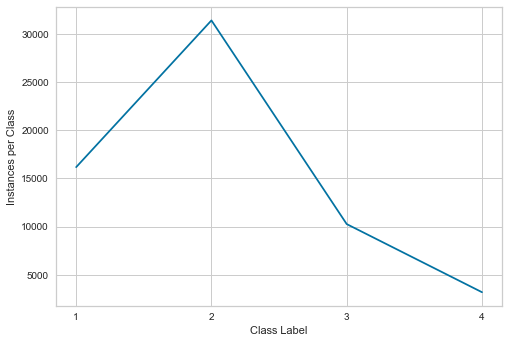

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = list(range(1, 1 + n_classes))

x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x)
fig = plt.figure()
plt.plot(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

## Convert to binary classification

In [115]:
classes = [0, 1]
n_classes = 2

df["BinnedCitations"][df["BinnedCitations"] == 1] = 0
df["BinnedCitations"][df["BinnedCitations"] == 2] = 1
df["BinnedCitations"][df["BinnedCitations"] == 3] = 1
df["BinnedCitations"][df["BinnedCitations"] == 4] = 1

[16171, 44848] [0, 1]


([<matplotlib.axis.XTick at 0x7fb638d4cee0>,
 <a list of 2 Text major ticklabel objects>)

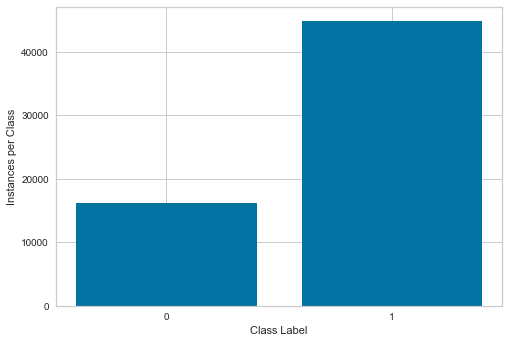

In [116]:
x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x, classes)
fig = plt.figure()
plt.bar(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

In [139]:
from sklearn.metrics import classification_report
features = [ 
    "AuthorProminence",
    "JournalNameRankNormalized",
    "PublisherRankNormalized",
    "AuthorRank",
    # "PageCount"
    ]
X = df.loc[:, features]
y = df.loc[:, "BinnedCitations"]

print(X.shape, y.shape)
print(classification_report(y, y))


(61019, 4) (61019,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16171
           1       1.00      1.00      1.00     44848

    accuracy                           1.00     61019
   macro avg       1.00      1.00      1.00     61019
weighted avg       1.00      1.00      1.00     61019



In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train_mini, y_train_mini = X_train[:1000], y_train[:1000]

In [154]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [161]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = xgb.predict(X_test)

print(confusion_matrix(y_true, y_pred, labels=classes))
print(classification_report(y_true, y_pred))

[[ 1955  2065]
 [  814 10421]]
              precision    recall  f1-score   support

           0       0.71      0.49      0.58      4020
           1       0.83      0.93      0.88     11235

    accuracy                           0.81     15255
   macro avg       0.77      0.71      0.73     15255
weighted avg       0.80      0.81      0.80     15255



In [156]:
print("Train performance")
print(xgb.score(X_train, y_train))
print("Test performance")
print(xgb.score(X_test, y_test))

Train performance
0.825430469364566
Test performance
0.8112749918059653


In [157]:
X_test_with_class = X_test.assign(predicted_class=y_pred, true_class=y_test)
X_test_with_class

,AuthorProminence,JournalNameRankNormalized,PublisherRankNormalized,AuthorRank,predicted_class,true_class
PaperId,,,,,,
2148928478,0,237.0,115.0,18.0,1,0
2550439385,0,172.0,275.0,1.0,1,1
1880174539,0,1230.0,525.0,1.0,1,1
2283913464,0,222.0,280.0,1.0,1,1
2156543648,0,326.0,194.0,1.0,1,1
...,...,...,...,...,...,...
2015512514,1,1042.0,369.0,198.0,1,1
2019726902,0,1383.0,533.0,25.0,1,1
407865814,1,1181.0,401.0,548.0,1,1


In [158]:
def get_rows_by_misclassification(X_test_with_class, true_class, predicted_class=None):
    if (predicted_class is not None):
        mask = (X_test_with_class["predicted_class"] == predicted_class) & (X_test_with_class["true_class"] == true_class)
    else:
        mask = (X_test_with_class["predicted_class"] != true_class) & (X_test_with_class["true_class"] == true_class)

    return X_test_with_class[mask]  

In [181]:
misclassified_high = get_rows_by_misclassification(X_test_with_class, 1, 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb60c50de20>]],
      dtype=object)

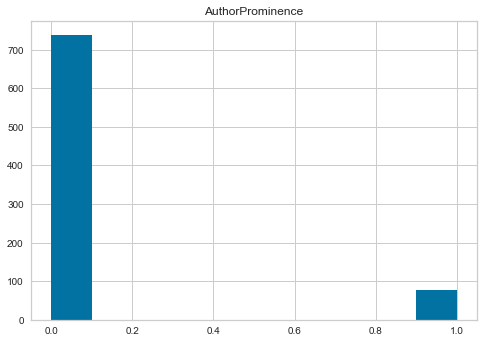

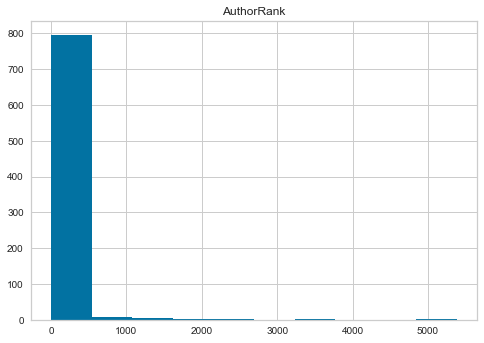

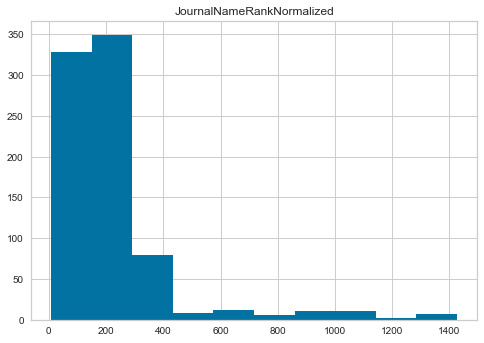

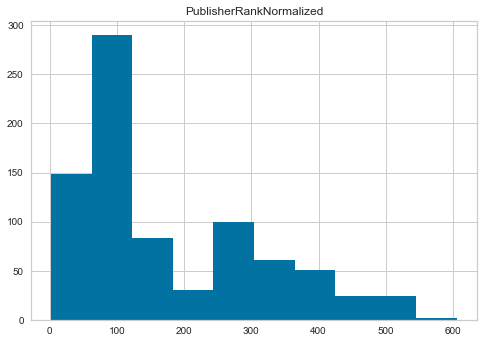

In [182]:
misclassified_high.hist("AuthorProminence")
misclassified_high.hist("AuthorRank")
misclassified_high.hist("JournalNameRankNormalized")
misclassified_high.hist("PublisherRankNormalized")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5e88697c0>]],
      dtype=object)

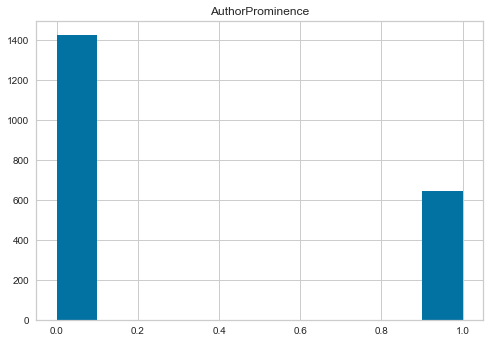

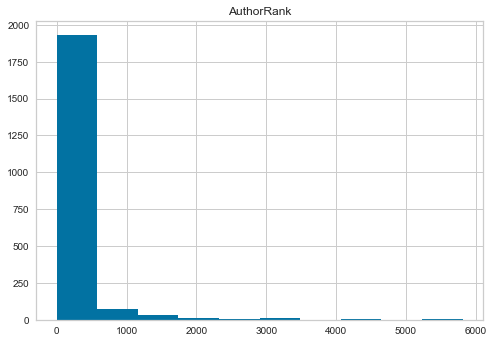

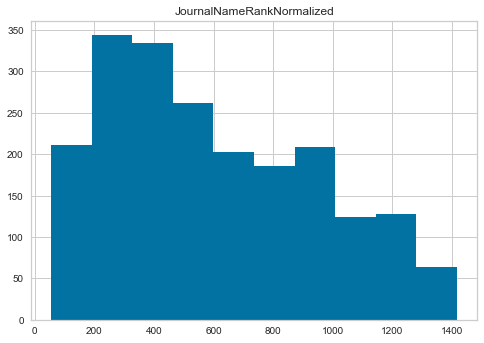

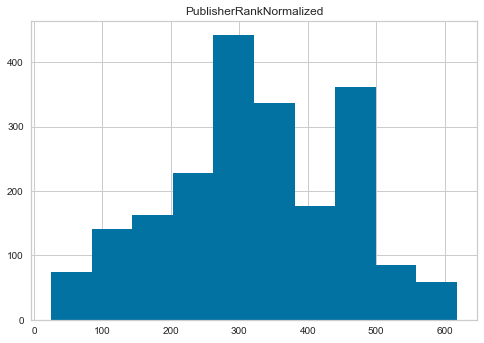

In [183]:
misclassified_low.hist("AuthorProminence")
misclassified_low.hist("AuthorRank")
misclassified_low.hist("JournalNameRankNormalized")
misclassified_low.hist("PublisherRankNormalized")

In [185]:
misclassified_high.columns

Index(['AuthorProminence', 'JournalNameRankNormalized',
       'PublisherRankNormalized', 'AuthorRank', 'predicted_class',
       'true_class'],
      dtype='object')

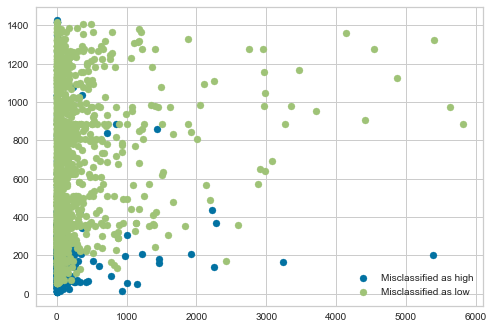

In [216]:
plt.scatter(misclassified_high["AuthorRank"], misclassified_high["JournalNameRankNormalized"])
plt.scatter(misclassified_low["AuthorRank"], misclassified_low["JournalNameRankNormalized"])
plt.legend(["Misclassified as high", "Misclassified as low"])

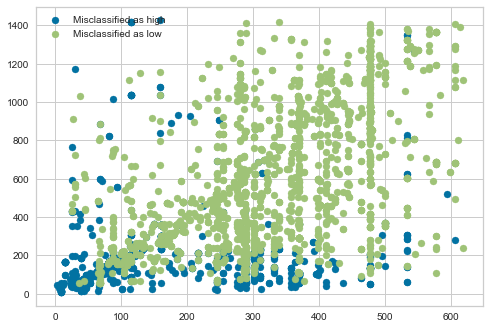

In [214]:
plt.scatter(misclassified_high["PublisherRankNormalized"], misclassified_high["JournalNameRankNormalized"])
plt.scatter(misclassified_low["PublisherRankNormalized"], misclassified_low["JournalNameRankNormalized"])
plt.legend(["Misclassified as high", "Misclassified as low"])